In [1]:
import numpy as np
from scipy.sparse.linalg import svds
from matplotlib import pyplot as plt
import fastplotlib as fpl
from tqdm import tqdm
from ipywidgets import interact

In [107]:
toy_shape = (5, 200)

In [149]:
p1 = 0.2
pixels = np.random.choice(a=[0, 1], size=toy_shape, p=[1-p1, p1])

In [150]:
tau = 10 # 4
max_amp = 255  # just to make saving as uint8 in opencv simple
amps_all = []
num_components = 5
num_frames = 200

for component_num in np.arange(num_components):
    amps = []
    amp = 0
    for time_step in np.arange(num_frames):
        if np.random.uniform(0,1) > 0.98:  #0.98
            amp = max_amp
        else:
            amp = np.max(np.array([amp - amp/tau, 0]));
        amps.append(amp)
    amps = np.array(amps)
    amps_all.append(amps)
pixels = np.array(amps_all)

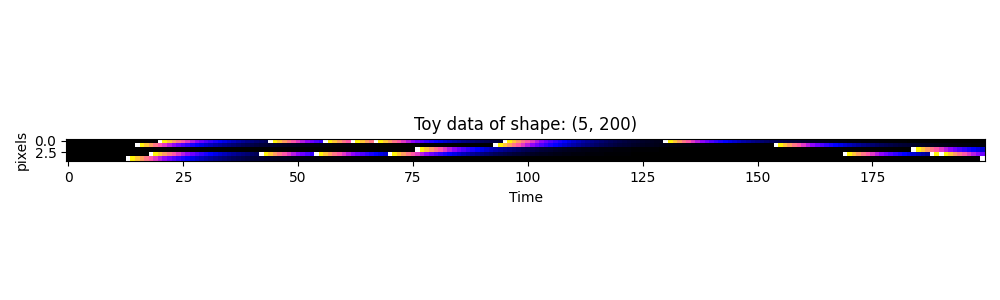

In [151]:
fig = plt.figure(figsize=(10, 3))
plt.imshow(pixels, cmap="gnuplot2")
plt.title(f"Toy data of shape: {toy_shape}")
plt.xlabel("Time")
plt.ylabel("pixels")
plt.tight_layout()
plt.show()

In [152]:
class TdSVD:
    def __init__(
        self,
        data: np.ndarray,
        n_time_steps: int,
        delay: int,
    ):
        self.n_time_steps = n_time_steps
        
        n_timepoints = data.shape[1]
        self.n_pixels = data.shape[0]
        
        self.A = np.zeros((self.n_pixels * n_time_steps, n_timepoints - (n_time_steps * delay)), dtype=np.float32)
        
        for pixel_ix in tqdm(range(self.n_pixels)):
            for step in range(n_time_steps):
                self.A[(n_time_steps * pixel_ix) + step] = np.roll(data[pixel_ix], shift=-delay * step)[:-n_time_steps * delay]

        self.k, self.U, self.S, self.V = None, None, None, None
    
    def fit(self, k=6, **kwargs):
        self.k = k
        self.U, self.S, self.V = svds(self.A, k=k, **kwargs)
        self.U = self.U[:, ::-1]
        self.S = self.S[::-1]
        self.V = self.V[::-1, :]

    def get_spatial(self):
        return self.U.reshape(self.n_pixels, self.n_time_steps, self.k)

In [153]:
%matplotlib ipympl

In [154]:
import seaborn as sns

In [155]:
tdsvd = None

In [157]:
@interact(n_time_steps=(1, 25), delay=(1, 50), k=(2, 10))
def plot_everything(n_time_steps: int = 5, delay: int = 1, k: int = 4):
    fig = plt.figure(figsize=(15, 10))
    grid = plt.GridSpec(10, 10)
    
    toy_plot = fig.add_subplot(grid[0, :])
    toy_plot.imshow(pixels, cmap="gnuplot2")
    toy_plot.set_title(f"Toy data of shape: {toy_shape}")
    toy_plot.set_xlabel("Time")
    toy_plot.set_ylabel("pixels")

    global tdsvd
    tdsvd = TdSVD(pixels, n_time_steps=n_time_steps, delay=delay)
    tdsvd.fit(k=k)
    
    plot_embed = fig.add_subplot(grid[1:7, :])
    plot_embed.imshow(tdsvd.A, cmap="gnuplot2")
    plot_embed.set_title(f"Time embedding, shape: {tdsvd.A.shape}, n_steps: {tdsvd.n_time_steps}")
    plot_embed.set_xlabel("Time")
    plot_embed.set_ylabel("pixels over steps")
    
    plot_svals = fig.add_subplot(grid[7:, :3])
    plot_svals.scatter(np.arange(tdsvd.S.size), tdsvd.S)
    plot_svals.set_yscale("log")
    for x, y in zip(np.arange(tdsvd.S.size), tdsvd.S):
        plot_svals.annotate(f"{y:.2e}", (x + 0.05, y))
    
    plot_svals.set_title("Singular values")
    
    plot_u = fig.add_subplot(grid[7:, 3:6])
    img_u = sns.heatmap(tdsvd.U, ax=plot_u, cmap="seismic")
    # fig.colorbar(img_u)
    plot_u.set_title(f"Left singular vectors, shape: {tdsvd.U.shape}")
    
    plot_v = fig.add_subplot(grid[7:, 6:])
    img_v = sns.heatmap(tdsvd.V, cmap="seismic", ax=plot_v)
    # fig.colorbar(img_v)
    plot_v.set_title(f"Right singular vectors, shape: {tdsvd.V.shape}")
    
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=5, description='n_time_steps', max=25, min=1), IntSlider(value=1, descri…

In [158]:
pixels.shape

(5, 200)

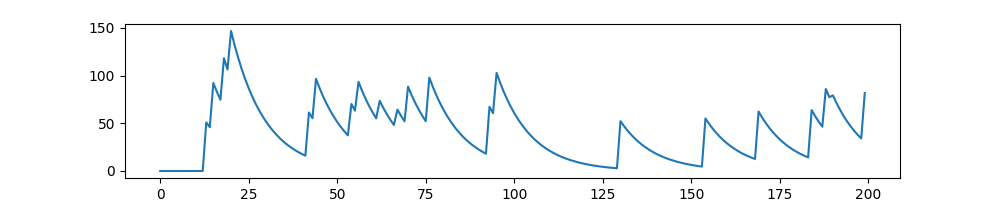

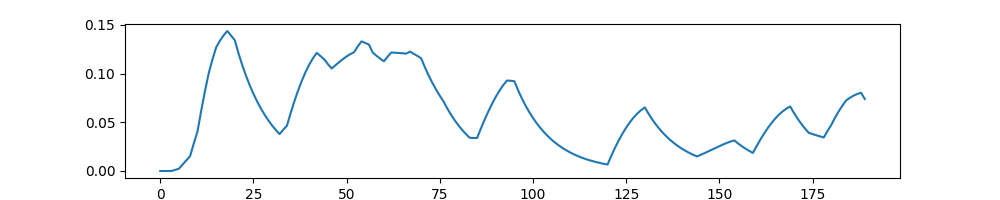

In [163]:
fig = plt.figure(figsize=(10, 2))
plt.plot(pixels.mean(axis=0))
plt.show()

fig = plt.figure(figsize=(10, 2))
plt.plot(tdsvd.V[0])
plt.show()